<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Initialize" data-toc-modified-id="1.-Initialize-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Initialize</a></span></li><li><span><a href="#2.-Upload-your-data" data-toc-modified-id="2.-Upload-your-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Upload your data</a></span></li><li><span><a href="#3.-Read-your-data" data-toc-modified-id="3.-Read-your-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Read your data</a></span></li><li><span><a href="#4.-Make-a-plot" data-toc-modified-id="4.-Make-a-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Make a plot</a></span></li><li><span><a href="#5.-Example-plots" data-toc-modified-id="5.-Example-plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5. Example plots</a></span><ul class="toc-item"><li><span><a href="#Example-1" data-toc-modified-id="Example-1-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Example 1</a></span></li><li><span><a href="#Example-2" data-toc-modified-id="Example-2-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Example 2</a></span></li><li><span><a href="#Example-3" data-toc-modified-id="Example-3-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Example 3</a></span></li></ul></li></ul></div>

<a href="https://colab.research.google.com/github/EstebanLT/HPLC/blob/main/Chromatogram_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Initialize
Run the following cell to import the required packages and declare the two main functions.

In [2]:
#@title Run this cell to start { display-mode: "form" }
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import gridspec
import zipfile
import unicodedata

# Function for translating all files to one dataframe
def get_run_df(path, skiprows=42, sort_cols=True, idx_inj=None, name_len=100, make_time_index=True, sep='\t', decimal=',', skip_name_elems=0):
    ''' Import the raw data from multiple samples as a single pandas dataframe.
    path: STRING, path where all the txt files are located.
    skiprows: int, number of rows to skip in the txt file before the data starts.
    sort_cols: BOOL, whether or not to sort the columns by injection number ()
    idx_inj: int, optional, position (separated by "_") in each filename indicating the injection number.
    name_len: int, optional, number of elements counting from the left in each filename (separated by "_") to keep as sample name.
    '''
    try:
        # Get the list of txt files in the indicated folder    
        # in case the folder is a zip
        if path.endswith('.zip'):
            zf = True
            zip_folder = zipfile.ZipFile(path)
            txts =  [n.filename for n in zip_folder.infolist() if n.filename.endswith('.txt') and not n.filename.startswith(('__MACOSX', '.DS_Store'))]
            
        # in case it's a regular folder
        else:
            zf = False
            txts = [i for i in os.listdir(path) if '.txt' in i]
            
        # Raise exception if no txt files found
        if len(txts) == 0:
            raise Exception('No txt files found in given path {}.'.format(path))
            
        # If an injection index is indicated, use it to reorder txt files
        if idx_inj:
            txts_dict = dict(zip(
                [int(t.split('/')[-1].split('_')[idx_inj].replace('.txt', '')) for t in txts],
                txts
            ))
            keys = list(txts_dict.keys())
            keys.sort()
            txts = [txts_dict[k] for k in keys]
            
        # Read the contents of all txt files (each txt file is one sample)
        df = pd.DataFrame(columns=['time'])
        for t in txts:
            # get sample name
            sname = '_'.join(t.split('/')[-1].replace('.txt','').split('_')[skip_name_elems:name_len])
            
            # read the sample's data
            # in case of zip folder
            try:
                if zf:
                    new_df = pd.read_csv(
                        zip_folder.open(t), 
                        sep=sep, decimal=decimal, skiprows=skiprows, header=0, 
                        names=['time', 'step', 'value'], 
                        usecols=['time', 'value'], encoding='utf-8'
                    )
                # in case of regular folder
                else:
                    new_df = pd.read_csv(
                        os.path.join(path, t), sep=sep, decimal=decimal, skiprows=skiprows, header=0, 
                        names=['time', 'step', 'value'], 
                        usecols=['time', 'value'], encoding='utf-8'
                    )
                # Fix the weird characters in the value column
                if new_df.value.dtype is not np.dtype("float64"):
                    if decimal == ".":
                        new_df['value'] = new_df.value.apply(
                            lambda x: unicodedata.normalize('NFKD', x)\
                            .replace(',', '')\
                            .replace(' ', '')).astype(np.float64)
                    else:
                        new_df['value'] = new_df.value.apply(
                            lambda x: unicodedata.normalize('NFKD', x)\
                            .replace(' ', '').replace(',','.')).astype(np.float64)
            except Exception as e:
                print("Found the following exception:", e)
                print("Type:", type(e))
            # Subtract the first time to all
            new_df['time'] = (new_df.time - new_df.time[0]).round(4)
            # rename the column "value" with the sample's name
            new_df.rename(columns={'value': sname}, inplace=True)
            df = pd.merge(left=df, right=new_df, how='outer', on='time', sort=True)
        if '_01_ED' in df:
            df = df.drop('_01_ED', axis=1).dropna()
        if sort_cols:
            cols = df.columns.to_list()[1:]
            cols.sort()
            df = df[['time'] + cols]
        if make_time_index:
            df = df.set_index('time')
            
        return df
    except Exception as e:
        print('Error: {}, file{}'.format(e, t))

# Function for drawing chromatogram plots
def plot_ics_chrom(
    df, cols,
    x_min=None, x_max=None, y_min=None, y_max=None,
    ax=None, log_y=False, shifty=0, shiftx=0, name_len=2, figsize=(8,3), dpi=300, no_negatives=False, ylabel='Charge (nC)', style='-', color=None, unlabel=False, labels_ontop=True, labshift=5, nwlabs=None):
    ''' Make a plot for a given set of columns in the dataset.
    df: pandas dataframe containing the chromatogram data.
    cols: list of column names to include in the plot.
    shifty: float or int, y axis shift between samples. 
    ax: optional, axes object on which to draw the plot.
    '''
    if ax is None:
        plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.axes()
    # Use the first 5 columns if cols was not modified
    if "column_name_1" in cols:
        cols = df.columns.to_list()[:5]
        print('No column names specified. Using the first {} columns.'.format(len(cols)))
    # Set the time as the x values
    if 'time' in df:
        df = df[cols + [time]].dropna()
        x = df.time
    else:
        df = df[cols].dropna()
        x = df.index.to_series()
    # Set the x limits for the plot
    if x_min is None:
        x_min = x.min()
    if x_max is None:
        x_max = x.max()
    x_min = max(x_min, x.min())
    x_max = min(x_max, x.max())
    # Adjust the data x_limits with the shift
    if isinstance(shiftx, dict):
        x_minb = x_min - max(shiftx.values())
        x_maxb = x_max - min(shiftx.values())
    else:
        x_minb = x_min - max(0, shiftx)*(len(cols)-1)
        x_maxb = x_max - min(shiftx, 0)*(len(cols)-1)
    
    # manage the styles
    if not isinstance(style, dict):
        style = dict(zip(cols,[style]*len(cols)))

    df = df[x.between(x_minb, x_maxb)]
    # Make any negative y values 0
    if log_y or no_negatives:
        df[df<0] = 0.0
    # Initialize iterative shifts to 0
    y_shift = 0
    x_shift = 0
    if color is None:
        color = dict(zip(cols, sns.color_palette('tab10', len(cols))))
    for col in cols:
        if nwlabs:
            label = nwlabs[col]
        else:
            label = ' '.join(col.split('_')[:name_len])
        if unlabel:
            label=None
        if isinstance(shifty, dict):
            y_shift = shifty[col]
        if isinstance(shiftx, dict):
            x_shift = shiftx[col]
        if isinstance(color, dict):
            c = color[col]
        else:
            c = color
        if isinstance(style, dict):
            sns.lineplot(x=x+x_shift, y=df[col]+y_shift, ax=ax, label=label, linestyle=style[col],
                     color=c
                    )
        if shifty and labels_ontop:
            ax.text(x_max, y_shift+labshift, label, va='bottom', ha='right')

        if not isinstance(shiftx, dict):
            x_shift += shiftx
        if not isinstance(shifty, dict):
            y_shift += shifty

    ax.legend(frameon=False)
    if isinstance(shifty, dict) or shifty>0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], frameon=False)
    if y_min is not None:
        ylims = ax.get_ylim()
        ax.set_ylim(y_min, ylims[1])
    if y_max is not None:
        ylims = ax.get_ylim()
        ax.set_ylim(ylims[0], y_max)
    if x_min is not None:
        xlims = ax.get_xlim()
        ax.set_xlim(x_min, xlims[1])
    if x_max is not None:
        xlims = ax.get_xlim()
        ax.set_xlim(xlims[0], x_max)
        
    ax.set_xlabel('Time (min)')
    ax.set_ylabel(ylabel)
    if log_y:
        ax.set_yscale('log')
    sns.despine(left=True)
    if shifty and labels_ontop:
        ax.legend().remove()
    return ax

## 2. Upload your data
On the left side, click on the folder icon and upload your data either as a zipped folder containing the raw data or individual txt files.

## 3. Read your data
Enter the path to your files as the variable called "path" in the cell below and run it. <br>
If needed, you can use more arguments in the get_run_df function (see the function above).

In [ ]:
path = "./my_file.zip"  # Replace "my_file.zip" with your file's name

df = get_run_df(path)

# Have a look at the first three rows of your dataframe and check if it looks good.
df.head(3)

## 4. Make a plot

In [ ]:
# Run this cell if you want to see a list of your dataframe's columns.
print(df.columns.to_list())

In [ ]:
# Introduce the names of the columns to include, separated by commas as shown in the example below.
# NOTE: The order in which you introduce the columns is the order in which the plots will appear
columns_to_include = ['column_name_1', 'column_name_2', 'column_name_3']

# Make the plot
# NOTE: shifty indicates how separated the plots will be (vertically).
# If you want them at the same height, set shifty to 0.
plot_ics_chrom(df, columns_to_include, shifty=100)

## 5. Example plots

### Example 1

In [3]:
# Read the data from a zipped folder
path = './sample_data/HPAEC-PAD-1/raw.zip'
df_1 = get_run_df(path, name_len=3)

In [6]:
# Alternatively, read the data from a regular folder
# path = './sample_data/HPAEC-PAD-1/raw/'
# df_1 = get_run_df(path, name_len=3)

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

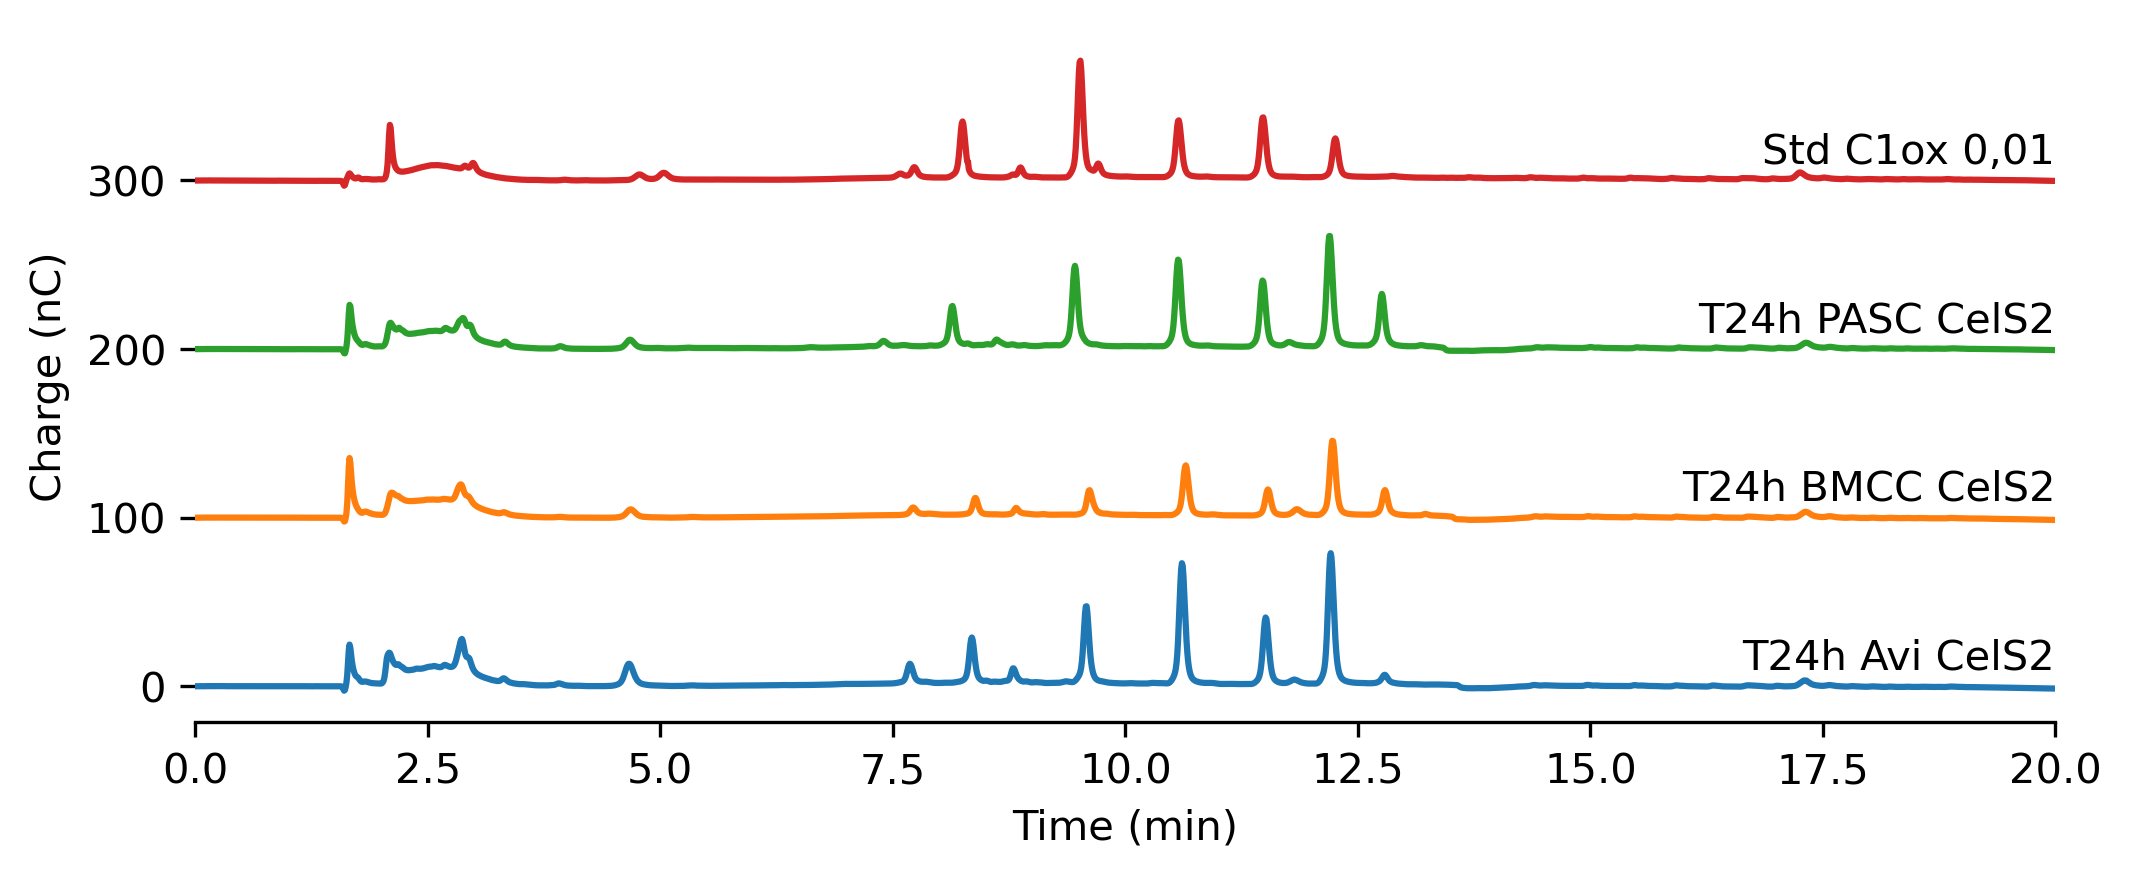

In [4]:
# Define the columns to include in the plot
cols = [c for c in df_1 if '24' in c and 'CelS2' in c] + [ 'Std_C1ox_0,01_x']
# Assign colors from the defautl color palette to each sample
colors = dict(zip(cols, sns.color_palette()))
# Draw plot
plot_ics_chrom(df_1, cols, name_len=3, shifty=100, x_min=0, x_max=20, color=colors)

### Example 2

In [5]:
path = './sample_data/HPAEC-PAD-2/raw/'
df_4 = get_run_df(path, skiprows=42, sort_cols=True, name_len=3)

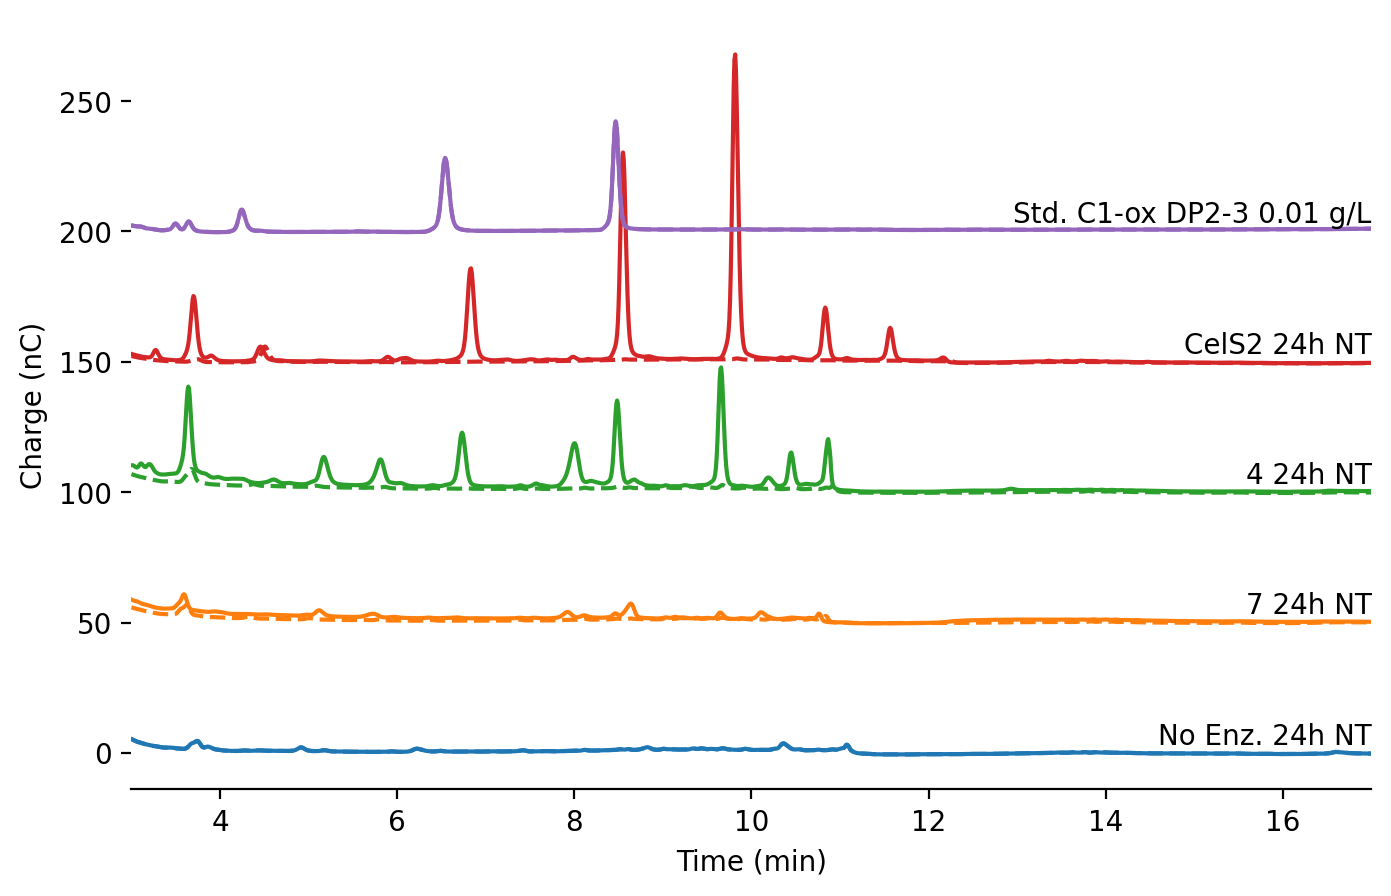

In [6]:
cols = [ 
    'C-NE_24h-NT_',
    '7_24h-NT_1',
    '4_24h-NT_1',
    'CelS2_24h-NT_1',
    'Std_C1ox-0.01_1'
]
cols_2 = [ 
    'C-NE_24h-NT_',
    '7_24h-NT_NA',
    '4_24h-NT_NA',
    'CelS2_24h-NT_NA',
    'Std_C1ox-0.01_1'
]

labs = [
    'No Enz. 24h NT',
    '7 24h NT',
    '4 24h NT',
    'CelS2 24h NT',
    'Std. C1-ox DP2-3 0.01 g/L',
]

shifty=50
colors = dict(zip(cols, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols)]))
colors_2 = dict(zip(cols_2, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols_2)]))
nwlabs=dict(zip(cols, labs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3, x_max=17,
    shifty=shifty,
    name_len=3,
    figsize=(8, 5), dpi=200,
    color=colors,
    nwlabs=nwlabs,
    labshift=1
)

# Draw
ax = plot_ics_chrom(
    df_4, cols_2, 
    log_y=False, 
    x_min=3, x_max=17,
    shifty=shifty,
    name_len=3,
    color=colors_2, style='--',
    labshift=1, ax=ax, unlabel=True
)

### Example 3

In [7]:
path_rz = './sample_data/UHPLC/raw/'
df_rz = get_run_df(path_rz, skiprows=42, sort_cols=True, idx_inj=-1, name_len=3)

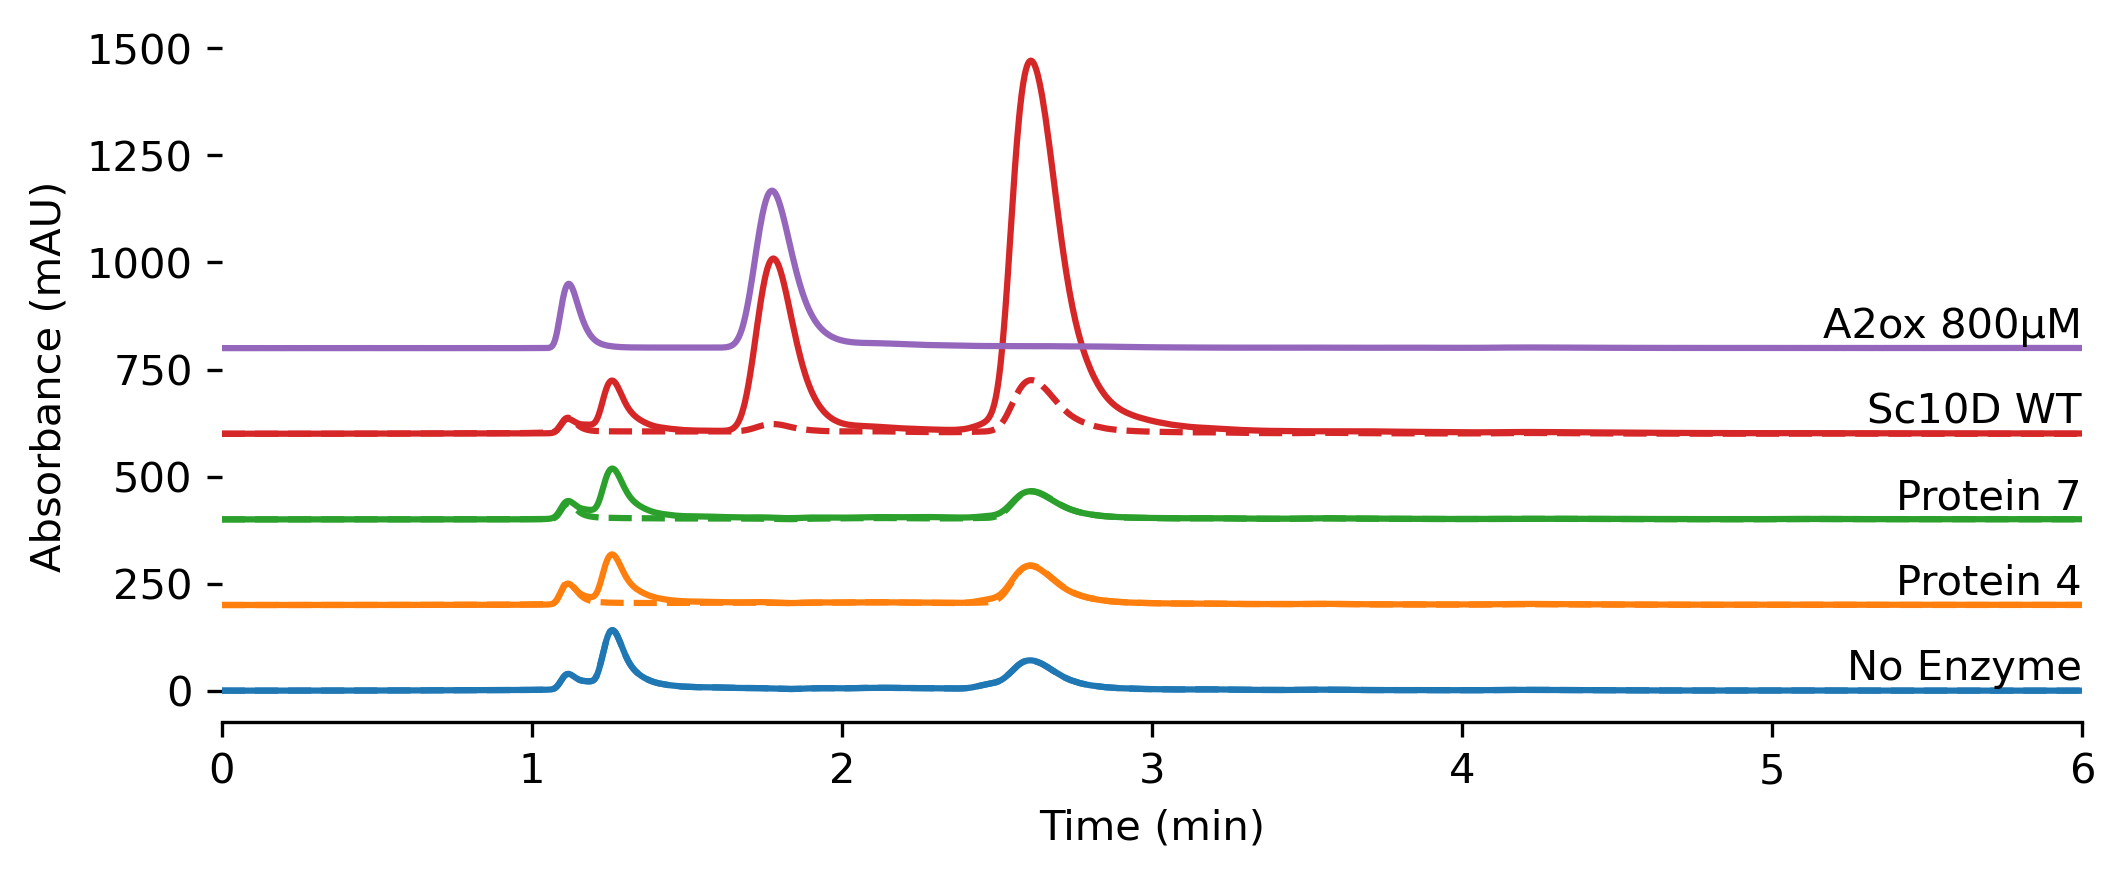

In [8]:
cols = ['C-NE_24h-ChiBS_']+[c for c in df_rz if '24h-ChiBS_1' in c] + [ 'A2ox_800µM_1']
nwlabs = ['No Enzyme', 'Protein 4', 'Protein 7', 'Sc10D WT', 'A2ox 800µM']
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=200, shiftx=0, name_len=2,
                    figsize=(8,3), dpi=300, nwlabs=dict(zip(cols,nwlabs)),
                    ylabel='Absorbance (mAU)',color = colors,
                    no_negatives=False)

cols = ['C-NE_24h-ChiBS_']+[c for c in df_rz if '24h-ChiBS_NA' in c] #+ [ 'A2ox_100µM_1']

colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, 
                    ax=ax, style='--',
                    log_y=False, shifty=200, shiftx=0, name_len=2,
#                     figsize=(8,3), dpi=300,
                    unlabel=True,
                    ylabel='Absorbance (mAU)',
                    color = colors,
                    no_negatives=False)